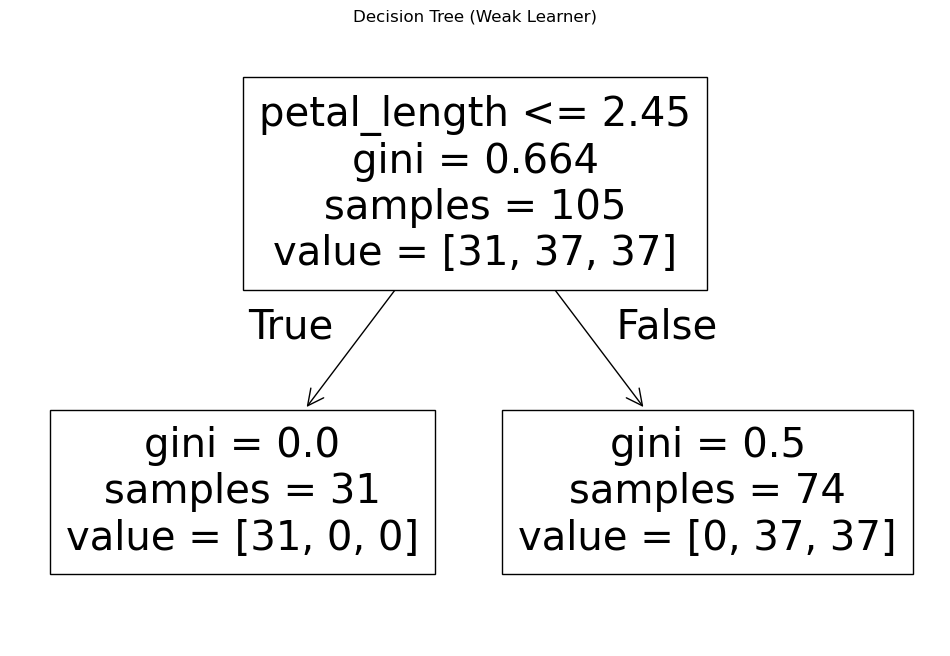

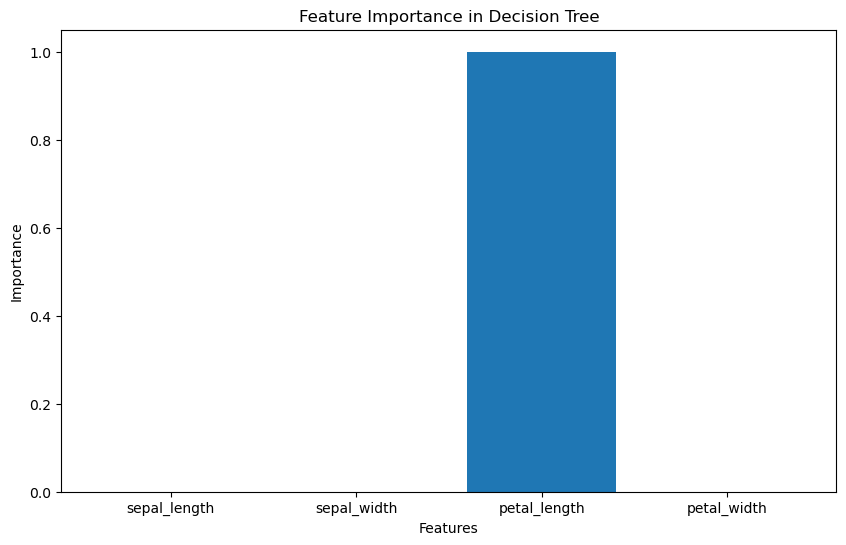

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
from sklearn.metrics import zero_one_loss

# Load the Iris dataset from URL
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris_df = pd.read_csv(url, header=None, 
                      names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])

# Convert string class labels to numeric values
class_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
iris_df['class_numeric'] = iris_df['class'].map(class_mapping)

X = iris_df.iloc[:, :-2].values  # All columns except class and class_numeric
y = iris_df['class_numeric'].values  # Use numeric class values
features_list = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Create a weak learner using DecisionTreeClassifier with limited depth/leaves
weak_learner = DecisionTreeClassifier(max_leaf_nodes=2)
dtree = weak_learner.fit(X_train, y_train)

# Plot the decision tree to understand the weak learner
plt.figure(figsize=(12, 8))
tree.plot_tree(dtree, feature_names=features_list)
plt.title("Decision Tree (Weak Learner)")
plt.show()

# Check feature importance in the weak learner
feature_importance = dtree.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(features_list)), feature_importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Decision Tree")
plt.xticks(range(len(features_list)), features_list)
plt.show()

In [58]:
# Step 4: Construct an AdaBoost classifier using the weak learner
adaboost_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_leaf_nodes=2),
    n_estimators=200,  # Start with higher number to observe convergence
    learning_rate=1.0,
    algorithm='SAMME'  # Use SAMME instead of deprecated SAMME.R
)

# Fit the model
adaboost_clf.fit(X_train, y_train)

# Make predictions
y_pred = adaboost_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Get the original class names for the classification report
class_names = list(class_mapping.keys())
y_test_original = [class_names[i] for i in y_test]
y_pred_original = [class_names[i] for i in y_pred]

# Print classification report with original class names
print("\nClassification Report:")
print(classification_report(y_test_original, y_pred_original))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.0000

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45


Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


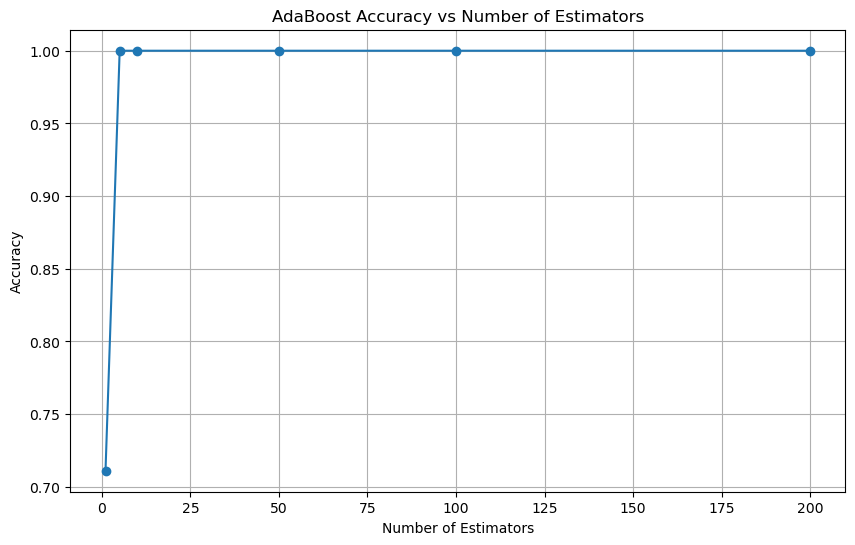

In [60]:
# Step 5 & 6: Experiment with parameters and evaluate performance

# Test different numbers of estimators
n_estimators_range = [1, 5, 10, 50, 100, 200]
accuracies = []

for n_estimators in n_estimators_range:
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_leaf_nodes=2),
        n_estimators=n_estimators,
        learning_rate=1.0,
        algorithm='SAMME'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot the accuracy vs. number of estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracies, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('AdaBoost Accuracy vs Number of Estimators')
plt.grid(True)
plt.show()

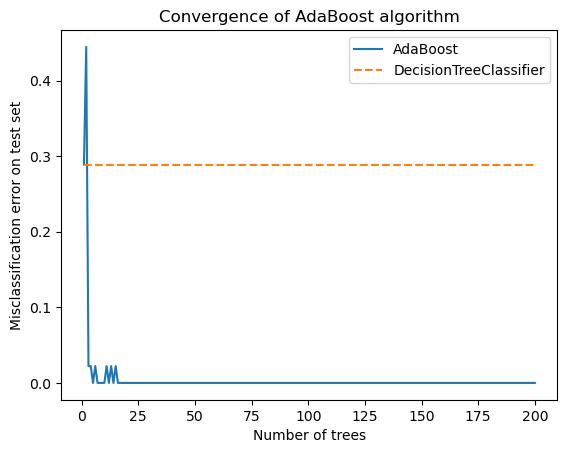

In [62]:
# Track the misclassification error as the number of estimators increases
n_estimators = 200  # Maximum number of estimators to track

# Create a DataFrame to hold the misclassification errors
boosting_errors = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators+1),
        "AdaBoost": [
            zero_one_loss(y_test, y_pred)
            for y_pred in adaboost_clf.staged_predict(X_test)
        ],
    }
).set_index("Number of trees")

# Plot the convergence
ax = boosting_errors.plot()
ax.set_ylabel("Misclassification error on test set")
ax.set_title("Convergence of AdaBoost algorithm")

# Plot comparison with a weak learner
plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [zero_one_loss(y_test, weak_learner.predict(X_test)), zero_one_loss(y_test, weak_learner.predict(X_test))],
    color="tab:orange",
    linestyle="dashed",
)

plt.legend(["AdaBoost", "DecisionTreeClassifier"], loc=1)
plt.show()

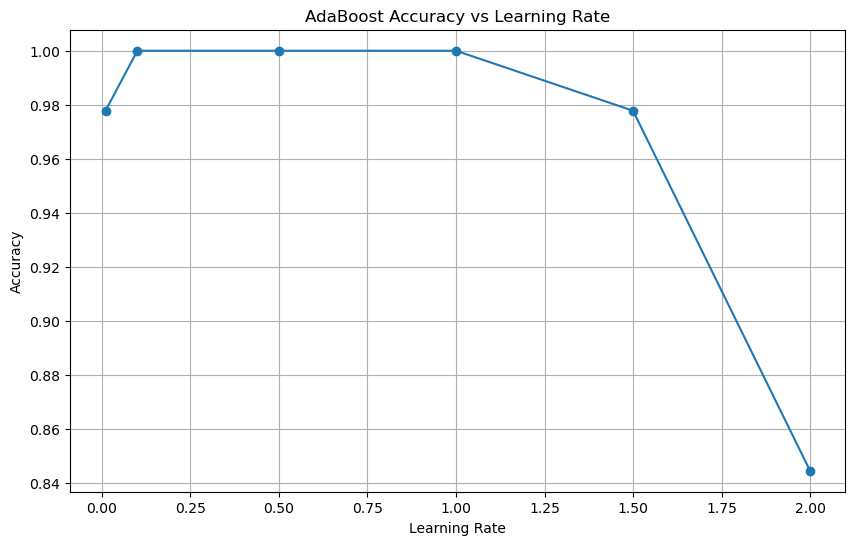

In [64]:
# Test different learning rates
learning_rates = [0.01, 0.1, 0.5, 1.0, 1.5, 2.0]
accuracies_lr = []

for lr in learning_rates:
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_leaf_nodes=2),
        n_estimators=50,  # Use a reasonable n_estimators based on convergence
        learning_rate=lr,
        algorithm='SAMME'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies_lr.append(accuracy_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, accuracies_lr, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('AdaBoost Accuracy vs Learning Rate')
plt.grid(True)
plt.show()

In [72]:
# Step 7: Create 2D plots for feature pairs and decision boundaries
# Updated function to plot in a grid
def plot_decision_boundaries_grid(X, y, weak_model, optimal_model, feature_pairs, feature_names, class_names):
    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(len(feature_pairs), 2, figsize=(15, 24))
    
    # Step size for the mesh grid
    h = 0.02
    
    # For each feature pair
    for i, pair in enumerate(feature_pairs):
        for j, (model, title) in enumerate(zip([weak_model, optimal_model], ["Small", "Optimal"])):
            ax = axes[i, j]
            
            # Extract the two features we're plotting
            f1, f2 = pair
            
            # Create a mesh grid
            x_min, x_max = X[:, f1].min() - 0.5, X[:, f1].max() + 0.5
            y_min, y_max = X[:, f2].min() - 0.5, X[:, f2].max() + 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            
            # Prepare mesh points for prediction
            mesh_points = np.c_[xx.ravel(), yy.ravel()]
            full_mesh_points = np.zeros((mesh_points.shape[0], X.shape[1]))
            feature_means = X.mean(axis=0)
            
            for k in range(X.shape[1]):
                if k in pair:
                    full_mesh_points[:, k] = mesh_points[:, [f1, f2].index(k)]
                else:
                    full_mesh_points[:, k] = feature_means[k]
            
            # Predict class labels for mesh points
            Z = model.predict(full_mesh_points)
            Z = Z.reshape(xx.shape)
            
            # Plot decision regions
            ax.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')
            
            # Plot training points
            for cls, color in enumerate(["#FF9999", "#66B2FF", "#99FF99"]):
                idx = np.where(y == cls)
                ax.scatter(X[idx, f1], X[idx, f2], c=color, label=class_names[cls], edgecolor='k')
            
            # Set title and labels
            ax.set_title(f'{feature_names[f1]} vs {feature_names[f2]} - {title}')
            ax.set_xlabel(feature_names[f1])
            ax.set_ylabel(feature_names[f2])
            
            # Only add legend to the first plot to avoid repetition
            if i == 0 and j == 0:
                ax.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()

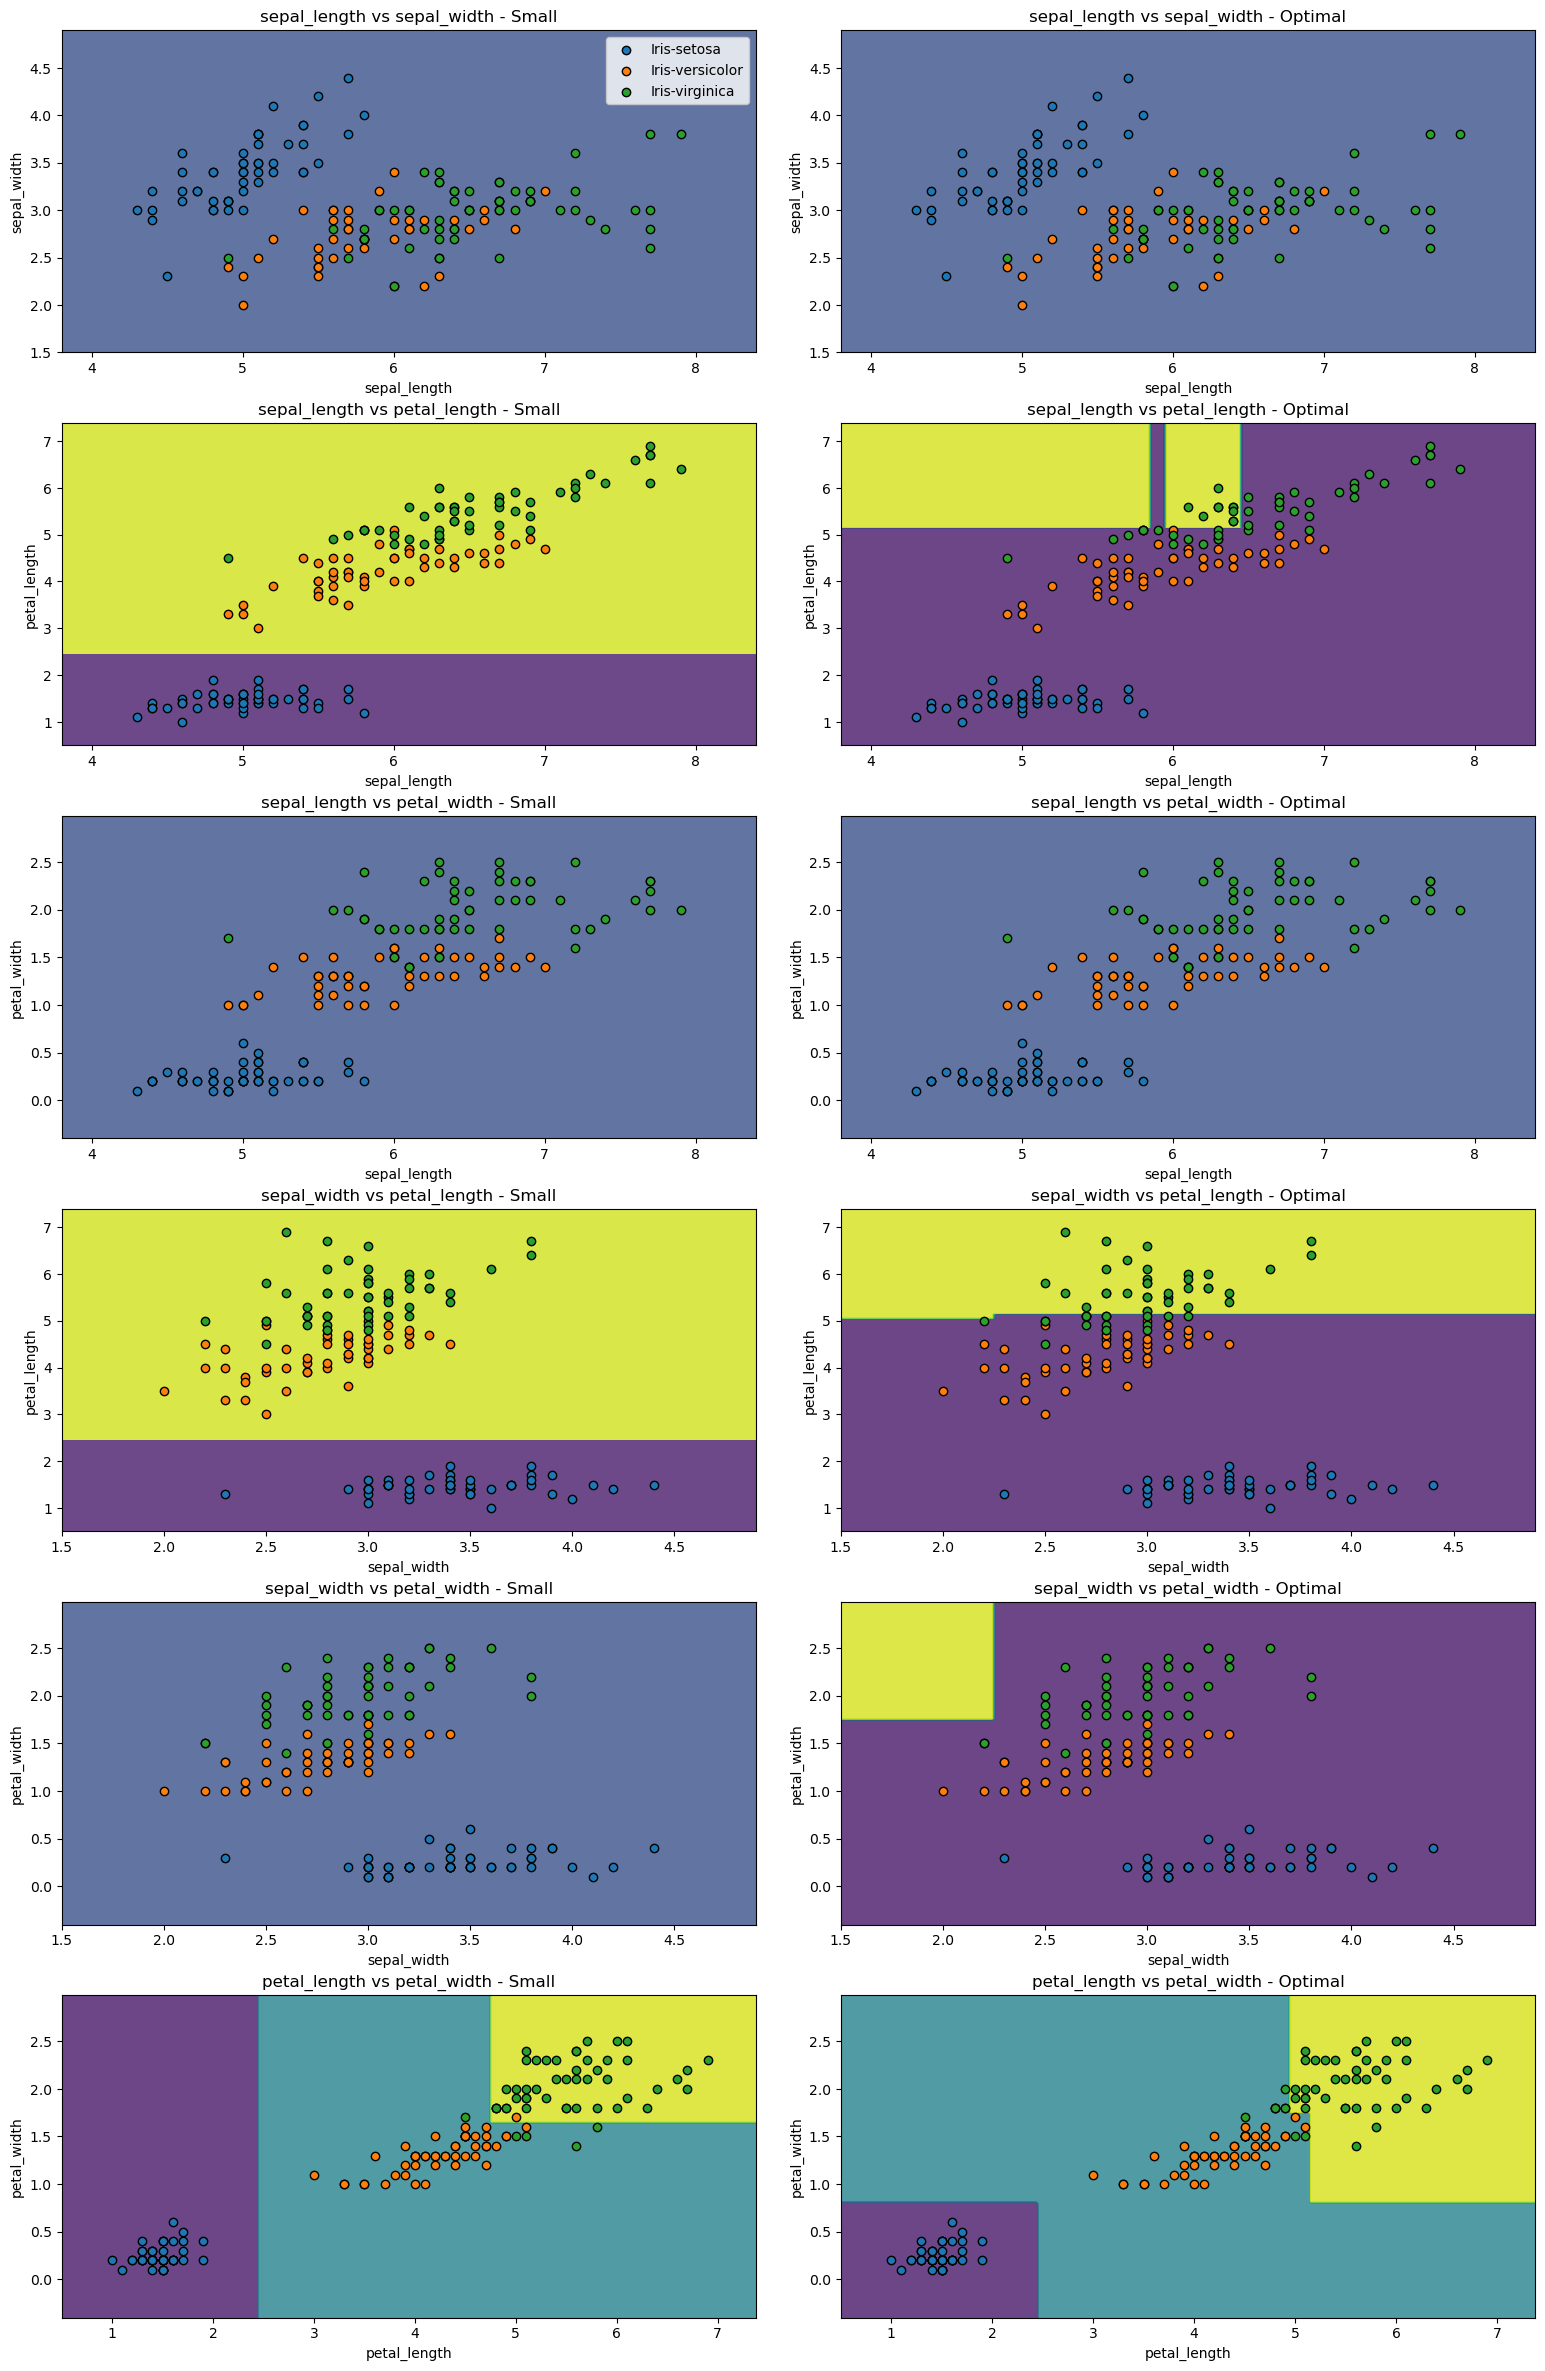


----- AdaBoost Classifier Analysis -----
Best accuracy achieved: 1.0000 with 5 estimators
Best learning rate: 0.1 with accuracy 1.0000

Feature Importance in the Optimal Model:
sepal_length: 0.0995
sepal_width: 0.1052
petal_length: 0.3938
petal_width: 0.4016

Key observations:
1. The petal dimensions (especially petal length) are the most discriminative features for iris classification
2. AdaBoost significantly improves the performance over a single weak decision tree
3. The algorithm converges after a certain number of estimators
4. The learning rate affects both the speed of convergence and the final accuracy
5. Feature pairs involving petal measurements show clearer class separation than those with only sepal measurements


In [76]:
# Create models with small and optimal number of estimators
weak_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_leaf_nodes=2),
    n_estimators=5,  # Small number
    learning_rate=1.0,
    algorithm='SAMME'
)
weak_model.fit(X_train, y_train)

optimal_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_leaf_nodes=2),
    n_estimators=50,  # Assuming this is optimal from previous analysis
    learning_rate=1.0,
    algorithm='SAMME'
)
optimal_model.fit(X_train, y_train)

# Features and their indices
feature_names = features_list
feature_pairs = [
    (0, 1),  # Sepal Length vs Sepal Width
    (0, 2),  # Sepal Length vs Petal Length
    (0, 3),  # Sepal Length vs Petal Width
    (1, 2),  # Sepal Width vs Petal Length
    (1, 3),  # Sepal Width vs Petal Width
    (2, 3)   # Petal Length vs Petal Width
]

# Define class names for plotting
class_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

# Create a grid of plots instead of individual plots
fig, axs = plt.subplots(6, 2, figsize=(16, 24))
fig.tight_layout(pad=3.0)

# Plot decision boundaries for both models and all feature pairs in a grid
for i, pair in enumerate(feature_pairs):
    # Create a mesh grid for the two features
    h = 0.02  # Step size
    x_min, x_max = X[:, pair[0]].min() - 0.5, X[:, pair[0]].max() + 0.5
    y_min, y_max = X[:, pair[1]].min() - 0.5, X[:, pair[1]].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # For each model (weak and optimal)
    for j, (model, title) in enumerate([(weak_model, "Small"), (optimal_model, "Optimal")]):
        ax = axs[i, j]
        
        # Create feature vectors for mesh points
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        full_mesh_points = np.zeros((mesh_points.shape[0], X.shape[1]))
        feature_means = X.mean(axis=0)
        
        for k in range(X.shape[1]):
            if k in pair:
                full_mesh_points[:, k] = mesh_points[:, [pair[0], pair[1]].index(k)]
            else:
                full_mesh_points[:, k] = feature_means[k]
        
        # Make predictions
        Z = model.predict(full_mesh_points)
        Z = Z.reshape(xx.shape)
        
        # Plot
        ax.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')
        
        # Plot the training points
        for cls_idx, cls_name in enumerate(class_names):
            idx = np.where(y == cls_idx)
            ax.scatter(X[idx, pair[0]], X[idx, pair[1]], 
                      label=cls_name if i==0 and j==0 else "", edgecolor='k')
        
        ax.set_xlabel(feature_names[pair[0]])
        ax.set_ylabel(feature_names[pair[1]])
        ax.set_title(f'{feature_names[pair[0]]} vs {feature_names[pair[1]]} - {title}')
        
        # Only add legend to the first plot
        if i == 0 and j == 0:
            ax.legend(loc="best")

plt.show()

# Rest of your code continues as before
learning_rates = [0.01, 0.1, 0.5, 1.0, 1.5, 2.0]
accuracies_lr = []
for lr in learning_rates:
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_leaf_nodes=2),
        n_estimators=50,
        learning_rate=lr,
        algorithm='SAMME'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies_lr.append(accuracy_score(y_test, y_pred))

# Summary and analysis
print("\n----- AdaBoost Classifier Analysis -----")
print(f"Best accuracy achieved: {max(accuracies):.4f} with {n_estimators_range[accuracies.index(max(accuracies))]} estimators")
print(f"Best learning rate: {learning_rates[accuracies_lr.index(max(accuracies_lr))]} with accuracy {max(accuracies_lr):.4f}")
print("\nFeature Importance in the Optimal Model:")
for i, importance in enumerate(optimal_model.feature_importances_):
    print(f"{feature_names[i]}: {importance:.4f}")

# Observations and discussion points
print("\nKey observations:")
print("1. The petal dimensions (especially petal length) are the most discriminative features for iris classification")
print("2. AdaBoost significantly improves the performance over a single weak decision tree")
print("3. The algorithm converges after a certain number of estimators")
print("4. The learning rate affects both the speed of convergence and the final accuracy")
print("5. Feature pairs involving petal measurements show clearer class separation than those with only sepal measurements")